# Introduction to Transfer Learning
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

### Lesson Reference
To supplement the presented material, consult the tutorial here: https://www.tensorflow.org/beta/tutorials/images/transfer_learning
* Freeze most layers, update only certain layer(s), then unfreeze all and update

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/04_02_CNN_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/SachsLab/IntracranialNeurophysDL/blob/master/notebooks/04_02_CNN_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### Normalize Environments
Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

In [1]:
from pathlib import Path
import os
import tensorflow as tf
import datetime
import numpy as np
import matplotlib.pyplot as plt

try:
    # See if we are running on google.colab
    from google.colab import files
    os.chdir('..')
    
    if not (Path.home() / '.kaggle').is_dir():
        # Configure kaggle
        uploaded = files.upload()  # Find the kaggle.json file in your ~/.kaggle directory.
        if 'kaggle.json' in uploaded.keys():    
            !mkdir -p ~/.kaggle
            !mv kaggle.json ~/.kaggle/
            !chmod 600 ~/.kaggle/kaggle.json
            
    if Path.cwd().stem != 'IntracranialNeurophysDL':
        if not (Path.cwd() / 'IntracranialNeurophysDL').is_dir():
            # Download the workshop repo and change to its directory
            !git clone --recursive https://github.com/SachsLab/IntracranialNeurophysDL.git
        os.chdir('IntracranialNeurophysDL')
        
    !pip install -q kaggle
    plt.style.use('dark_background')
    IN_COLAB = True
    
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
    # Make sure the kaggle executable is on the PATH
    os.environ['PATH'] = os.environ['PATH'] + ';' + str(Path(sys.executable).parent / 'Scripts')

# Try to clear any logs from previous runs
if (Path.cwd() / 'logs').is_dir():
    import shutil
    try:
        shutil.rmtree(str(Path.cwd() / 'logs'))
    except PermissionError:
        print("Unable to remove logs directory.")

from indl import turbo_cmap, reset_keras
plt.rcParams.update({
    'axes.titlesize': 24,
    'axes.labelsize': 20,
    'lines.linewidth': 3,
    'lines.markersize': 10,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 18
})
%load_ext autoreload
%autoreload 2

In [3]:
# Download and unzip data
datadir = Path.cwd() / 'data' / 'kjm_ecog'
if not (datadir / 'converted').is_dir():
    !kaggle datasets download --unzip --path {str(datadir / 'converted' / 'faces_basic')} cboulay/kjm-ecog-faces-basic
    print("Finished downloading and extracting data.")
else:
    print("Data directory found. Skipping download.")

Data directory found. Skipping download.


## Strategy

The model comprises a block for temporal filters, a block for a spatial filter, a block for further convolutional layers, and a block for the classifier. The spatial filter is going to be unique to each recording, but the other blocks could be shared across recordings.

If we start with a well-performing model for one recording then whenever we switch to a new recording the different sensor locations are going to be a poor fit and create large errors. We don't want those errors to propagate through and update weights in the entire model. For each new recording, we freeze the layers that are shared so they don't update, and we allow only the spatial filter to update. After the spatial filter has updated, we can then unfreeze all layers to perform fine tuning at a lower learning rate.

### Get basic info about each recording

We need to know the data shape for each recording.
We are also goign to take this opportunity to pre-determine the training/validation sets for each recording.

In [4]:
participant_names = ['aa', 'ap', 'ca', 'de', 'fp', 'ha', 'ja',
                     'jm', 'jt', 'mv', 'rn', 'rr', 'wc', 'zt']
test_participant = 'ca'  # To validate the transfer-learning model vs a naive model.
train_participants = [_ for _ in participant_names if _ != test_participant]

In [5]:
from data.utils.fileio import load_faces_houses
from collections import OrderedDict
from sklearn.model_selection import StratifiedShuffleSplit

P_TRAIN = 0.8

rec_infos = OrderedDict()
for p_name in participant_names:
    X, Y, ax_info = load_faces_houses(datadir, p_name, feature_set='full')
    n_trials = len(ax_info['instance_data'])
    sss = StratifiedShuffleSplit(n_splits=1, train_size=P_TRAIN, random_state=0)
    trn, tst = next(sss.split(X, Y))
    rec_infos[p_name] = {
        'n_trials': n_trials,
        'n_timestamps': len(ax_info['timestamps']),
        'fs': ax_info['fs'],
        'n_channels': len(ax_info['channel_names']),
        'trn': trn,
        'tst': tst
    }
    
print([(p_name, info['n_channels']) for p_name, info in rec_infos.items()])

[('aa', 46), ('ap', 41), ('ca', 50), ('de', 31), ('fp', 52), ('ha', 39), ('ja', 60), ('jm', 56), ('jt', 102), ('mv', 58), ('rn', 42), ('rr', 40), ('wc', 39), ('zt', 58)]


### Define the model in parts

In [6]:
# EEGNet-like model with a pair of parallel input layers.
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import layers

def make_models(T, aug_offset=100, n_classes=3,
                n_temporal_short=8, len_temporal_short=28,
                n_temporal_long=4, len_temporal_long=220,
                D=2,
                activation='relu',
                downsamp_1=8,
                n_pointwise_filters=25,
                len_kernel_2=47, downsamp_2=5,
                norm_rate=0.45, dropout_rate=0.45, l1_reg=0.01, l2_reg=0.01,
                rec_infos={}):

    # Shared head block:
    # Temporal kernel convolutions.
    head_input = tf.keras.Input(shape=(T - aug_offset, None, 1))
    _y_short = layers.Conv2D(n_temporal_short, (len_temporal_short, 1),
                             padding='same', use_bias=False)(head_input)
    _y_long = layers.Conv2D(n_temporal_long, (len_temporal_long, 1),
                            padding='same', use_bias=False)(head_input)
    _y_head = layers.Concatenate(axis=-1)([_y_short, _y_long])
    _y_head = layers.BatchNormalization(axis=-1)(_y_head)
    shared_head = tf.keras.Model(inputs=head_input, outputs=_y_head, name='shared_head')
    shared_head.summary()
    shared_head.save(datadir / 'models' / 'shared_head_naive.h5')
    
    # Skip over the spatial filter for now
    
    # Shared tail block: Feature aggregation and classification
    tail_input = tf.keras.Input(shape=(T - aug_offset, 1, (n_temporal_short + n_temporal_long) * D))
    tail_y = layers.AveragePooling2D((downsamp_1, 1))(tail_input)
    tail_y = layers.Dropout(dropout_rate)(tail_y)
    tail_y = layers.SeparableConv2D(n_pointwise_filters, (len_kernel_2, 1), padding='valid', use_bias=False)(tail_y)
    tail_y = layers.Activation(activation)(tail_y)
    tail_y = layers.BatchNormalization(axis=-1)(tail_y)
    tail_y = layers.AveragePooling2D((downsamp_2, 1))(tail_y)
    tail_y = layers.Dropout(dropout_rate)(tail_y)
    tail_y = layers.Flatten()(tail_y)
    tail_y = layers.Dense(n_classes, kernel_constraint=max_norm(norm_rate))(tail_y)
    tail_y = layers.Activation('softmax')(tail_y)
    shared_tail = tf.keras.Model(inputs=tail_input, outputs=tail_y, name='shared_tail')
    shared_tail.summary()
    shared_tail.save(datadir / 'models' / 'shared_tail_naive.h5')
    
    # Now we create unique spatial filter model parts for each participant
    ss_layers = OrderedDict()
    for ss_name, ss_info in rec_infos.items():
        ss_layers[ss_name] = [
            layers.DepthwiseConv2D((1, ss_info['n_channels']), use_bias=False,
                                   depth_multiplier=D,
                                   kernel_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
                                   depthwise_regularizer=tf.keras.regularizers.l1_l2(l1=l1_reg, l2=l2_reg),
                                   depthwise_constraint=max_norm(1.)),
            layers.Activation(activation),
            layers.BatchNormalization(axis=-1)
        ]
            
    return shared_head, shared_tail, ss_layers

In [7]:
MAX_OFFSET = 100
T = rec_infos[test_participant]['n_timestamps']  # All recordings should have same timestamps.

shared_head, shared_tail, ss_layers = make_models(
    T, n_classes=len(np.unique(Y)), aug_offset=MAX_OFFSET, rec_infos=rec_infos)

Model: "shared_head"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 701, None, 1 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 701, None, 8) 224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 701, None, 4) 880         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 701, None, 12 0           conv2d[0][0]                     
                                                                 conv2d_1[0][0]         

In [ ]:
tf.keras.utils.plot_model(shared_head)

In [ ]:
tf.keras.utils.plot_model(shared_tail)

In [8]:
reset_keras(shared_head)
reset_keras(shared_tail)

7
184


#### Prepare Data

In [9]:
def get_ds_train_valid(X, Y, trn, tst, batch_size=5, max_offset=0):
    # Convert Y from strings to integers.
    classes, y = np.unique(Y, return_inverse=True)
    n_trials = len(y)
    n_subsamps = X.shape[1] - max_offset
    
    def augmentation_fn(x_dat, y_dat):
        # Randomly select an integer between 0 and max_offset
        t_offset = tf.random.uniform(shape=[], minval=0, maxval=max_offset, dtype=tf.int32)
        # Slice the data to keep samples from t_offset to t_offset + n_subsamps
        # tf.slice syntax arguments are: data, slice starts (per dim), slice length (per dim)
        # Though -1 as a length is special, and means to take all.
        x_dat = tf.slice(x_dat, [t_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def augmentation_valid_fn(x_dat, y_dat):
        # For validation data, take only the last n_subsamps
        x_dat = tf.slice(x_dat, [max_offset, 0, 0], [n_subsamps, -1, -1])
        return x_dat, y_dat
    
    def preprocess_fn(x_dat, y_dat):
        # Data are by default 64-bit. GPUs work better with 32-bit (or even 16-bit, depending)
        x_dat = tf.cast(x_dat, tf.float32)
        # keras Conv layers expect a 'colour depth' dimension.
        x_dat = tf.expand_dims(x_dat, -1)
        y_dat = tf.cast(y_dat, tf.uint8)
        return x_dat, y_dat
    
    # Separate input data into training and validation sets.
    X_train, X_valid, y_train, y_valid = X[trn], X[tst], y[trn], y[tst]
    n_train = len(y_train)
    ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    ds_valid = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
    
    # Prepare (queue?) functions to be run on the data.
    ds_train = ds_train.map(preprocess_fn)
    ds_valid = ds_valid.map(preprocess_fn)
    if max_offset > 0:
        ds_train = ds_train.map(augmentation_fn)
        ds_valid = ds_valid.map(augmentation_valid_fn)
    ds_train = ds_train.shuffle(n_train + 1).batch(batch_size, drop_remainder=True)
    ds_valid = ds_valid.batch(batch_size)
    
    return ds_train, ds_valid, n_train

### Warm Start: Training a model normally with one recording

In [10]:
BATCH_SIZE = 10
N_EPOCHS = 50
p_name = participant_names[-1]

In [11]:
X, Y, ax_info = load_faces_houses(datadir, p_name, feature_set='full')

ds_train, ds_valid, n_train = get_ds_train_valid(X, Y,
                                                 rec_infos[p_name]['trn'],
                                                 rec_infos[p_name]['tst'],
                                                 batch_size=BATCH_SIZE,
                                                 max_offset=MAX_OFFSET)

xfer_model = tf.keras.Sequential([
    tf.keras.models.load_model(datadir / 'models' / 'shared_head_naive.h5'),
    *ss_layers[p_name],
    tf.keras.models.load_model(datadir / 'models' / 'shared_tail_naive.h5')
], name='xfer_full')
xfer_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])
xfer_model.summary()
tf.keras.utils.plot_model(xfer_model)

W0910 01:41:50.981152 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 01:41:51.056274 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Model: "xfer_full"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shared_head (Model)          (None, 701, None, 12)     1152      
_________________________________________________________________
depthwise_conv2d_13 (Depthwi (None, 701, None, 24)     1392      
_________________________________________________________________
activation_15 (Activation)   (None, 701, None, 24)     0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 701, None, 24)     96        
_________________________________________________________________
shared_tail (Model)          (None, 3)                 2431      
Total params: 5,071
Trainable params: 4,949
Non-trainable params: 122
_________________________________________________________________
Epoch 1/50
48/48 [==============================] - 5s 98ms/step - loss: 1.5541 - accuracy: 0.5375 - val_loss: 0.0000e+

In [ ]:
history = xfer_model.fit(x=ds_train, epochs=N_EPOCHS, validation_data=ds_valid, verbose=1)

xfer_model.layers[0].save(datadir / 'models' / 'shared_head.h5')
xfer_model.layers[-1].save(datadir / 'models' / 'shared_tail.h5')

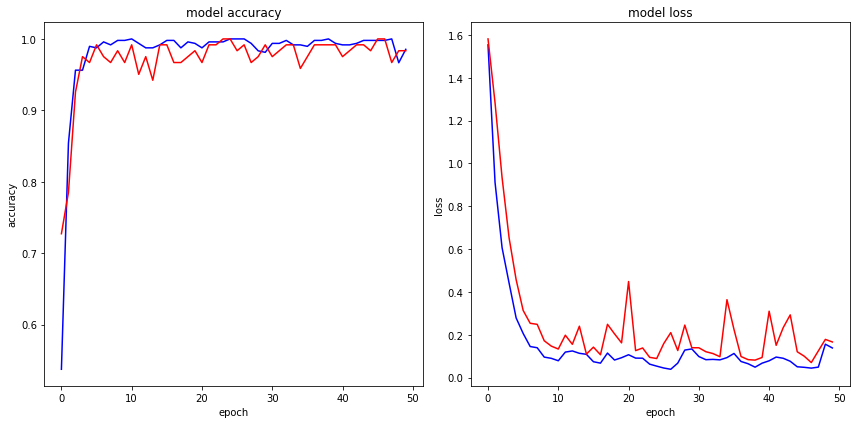

In [12]:
fig = plt.figure(figsize=(12, 6), facecolor='white')
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'b')
plt.plot(history.history['val_accuracy'], 'r')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
# plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.tight_layout()

plt.show()

### Train model for each recording with freezing then fine-tuning

In [13]:
BATCH_SIZE = 10
N_EPOCHS_SF = 40
N_EPOCHS_FINETUNE = 60
N_ITERS_ACROSS_SESS = 4
LR_SPAT_FILT = 0.0003
LR_FINE_TUNE = LR_SPAT_FILT / 10

In [14]:
hists = {}
for ep_ix in range(N_ITERS_ACROSS_SESS):
    for p_ix, p_idx in enumerate(np.random.permutation(len(train_participants))):
        
        p_name = train_participants[p_idx]
        rec_info = rec_infos[p_name]
        
        # Load data for this session
        X, Y, ax_info = load_faces_houses(datadir, p_name, feature_set='full')
        
        # Prepare the data for DL
        ds_train, ds_valid, n_train = get_ds_train_valid(X, Y,
                                                         rec_info['trn'],
                                                         rec_info['tst'],
                                                         batch_size=BATCH_SIZE,
                                                         max_offset=MAX_OFFSET)
        
        # Build the model for this session by combining shared layers
        # and individual layer. Each sub-model should keep its weights
        # from previous training.
        _model = tf.keras.Sequential([
            tf.keras.models.load_model(datadir / 'models' / 'shared_head.h5'),
            *ss_layers[p_name],
            tf.keras.models.load_model(datadir / 'models' / 'shared_tail.h5')
        ], name=p_name + '_full')
        
        # Freeze layers and compile with correct optimizer lr.
        _model.layers[0].trainable = False
        _model.layers[-1].trainable = False
        optimizer = tf.keras.optimizers.RMSprop(lr=LR_SPAT_FILT)
        _model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=optimizer, metrics=['accuracy'])
        
        if ep_ix == 0 and p_ix == 0:
            _model.summary()
            
        # Train model
        print("Training model {} ({} of {})".format(_model.name, ep_ix + 1,
                                                    N_ITERS_ACROSS_SESS))
        hist_1 = _model.fit(x=ds_train,
                            epochs=N_EPOCHS_SF,
                            validation_data=ds_valid,
                            verbose=0)
        print("Ending acc and val acc: {:.3f}, {:.3f}".format(
            hist_1.history['accuracy'][-1], hist_1.history['val_accuracy'][-1]))
        
        # Fine-tune model
        # Unfreeze layers and compile.
        _model.layers[0].trainable = True
        _model.layers[-1].trainable = True
        optimizer = tf.keras.optimizers.RMSprop(lr=LR_FINE_TUNE)
        _model.compile(loss='sparse_categorical_crossentropy',
                       optimizer=optimizer, metrics=['accuracy'])
        
        if ep_ix == 0 and p_ix == 0:
            _model.summary()
        
        print("Fine-tuning model {} ({} of {})".format(_model.name, ep_ix + 1,
                                                       N_ITERS_ACROSS_SESS))
        hist_2 = _model.fit(x=ds_train,
                            epochs=N_EPOCHS_FINETUNE,
                            validation_data=ds_valid,
                            verbose=0)
        print("Ending acc and val acc: {:.3f}, {:.3f}".format(
            hist_2.history['accuracy'][-1], hist_2.history['val_accuracy'][-1]))
        
        if p_name not in hists:
            hists[p_name] = []
        hists[p_name].append(hist_1.history)
        hists[p_name].append(hist_2.history)
        
        _model.layers[0].save(datadir / 'models' / 'shared_head.h5')
        _model.layers[-1].save(datadir / 'models' / 'shared_tail.h5')

W0910 01:47:41.627579 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 01:47:41.705214 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Model: "rn_full"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
shared_head (Model)          (None, 701, None, 12)     1152      
_________________________________________________________________
depthwise_conv2d_10 (Depthwi (None, 701, None, 24)     1008      
_________________________________________________________________
activation_12 (Activation)   (None, 701, None, 24)     0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 701, None, 24)     96        
_________________________________________________________________
shared_tail (Model)          (None, 3)                 2431      
Total params: 4,687
Trainable params: 1,056
Non-trainable params: 3,631
_________________________________________________________________
Training model rn_full (1 of 4)
Ending acc and val acc: 0.894, 0.807
Model: "rn_full"
_________________________________

W0910 01:48:29.784318 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 01:48:29.860144 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ap_full (1 of 4)
Ending acc and val acc: 0.940, 0.875
Fine-tuning model ap_full (1 of 4)
Ending acc and val acc: 0.942, 0.883


W0910 01:49:17.690902 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 01:49:17.766867 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rr_full (1 of 4)
Ending acc and val acc: 0.929, 0.703
Fine-tuning model rr_full (1 of 4)
Ending acc and val acc: 0.964, 0.757


W0910 01:49:33.572341 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 01:49:33.647854 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model de_full (1 of 4)
Ending acc and val acc: 0.958, 0.917
Fine-tuning model de_full (1 of 4)
Ending acc and val acc: 0.973, 0.934


W0910 01:50:14.157488 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 01:50:14.232671 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ha_full (1 of 4)
Ending acc and val acc: 0.928, 0.838
Fine-tuning model ha_full (1 of 4)
Ending acc and val acc: 0.991, 0.880


W0910 01:50:59.391666 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 01:50:59.467636 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jt_full (1 of 4)
Ending acc and val acc: 0.955, 0.845
Fine-tuning model jt_full (1 of 4)
Ending acc and val acc: 0.991, 0.869


W0910 01:52:08.317651 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 01:52:08.393393 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model mv_full (1 of 4)
Ending acc and val acc: 0.962, 0.860
Fine-tuning model mv_full (1 of 4)
Ending acc and val acc: 0.992, 0.901


W0910 01:53:09.509543 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 01:53:09.586360 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model fp_full (1 of 4)
Ending acc and val acc: 0.983, 0.959
Fine-tuning model fp_full (1 of 4)
Ending acc and val acc: 0.996, 0.975


W0910 01:54:05.005675 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 01:54:05.081533 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jm_full (1 of 4)
Ending acc and val acc: 0.935, 0.769
Fine-tuning model jm_full (1 of 4)
Ending acc and val acc: 0.967, 0.821


W0910 01:55:01.609725 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 01:55:01.686641 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ja_full (1 of 4)
Ending acc and val acc: 0.987, 0.839
Fine-tuning model ja_full (1 of 4)
Ending acc and val acc: 0.994, 0.898


W0910 01:56:03.197367 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 01:56:03.274744 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model aa_full (1 of 4)
Ending acc and val acc: 0.958, 0.845
Fine-tuning model aa_full (1 of 4)
Ending acc and val acc: 0.991, 0.864


W0910 01:56:49.804066 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 01:56:49.880974 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model wc_full (1 of 4)
Ending acc and val acc: 0.985, 0.958
Fine-tuning model wc_full (1 of 4)
Ending acc and val acc: 0.991, 0.983


W0910 01:57:36.733334 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 01:57:36.811332 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model zt_full (1 of 4)
Ending acc and val acc: 0.996, 0.992
Fine-tuning model zt_full (1 of 4)
Ending acc and val acc: 1.000, 1.000


W0910 01:58:37.787746 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 01:58:37.865674 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model mv_full (2 of 4)
Ending acc and val acc: 0.990, 0.851
Fine-tuning model mv_full (2 of 4)
Ending acc and val acc: 0.998, 0.926


W0910 01:59:38.890796 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 01:59:38.968362 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model zt_full (2 of 4)
Ending acc and val acc: 0.998, 0.983
Fine-tuning model zt_full (2 of 4)
Ending acc and val acc: 0.998, 0.992


W0910 02:00:39.552692 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:00:39.629846 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model wc_full (2 of 4)
Ending acc and val acc: 0.994, 0.933
Fine-tuning model wc_full (2 of 4)
Ending acc and val acc: 0.994, 0.983


W0910 02:01:26.164362 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:01:26.241520 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jt_full (2 of 4)
Ending acc and val acc: 0.988, 0.893
Fine-tuning model jt_full (2 of 4)
Ending acc and val acc: 0.997, 0.917


W0910 02:02:33.852254 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:02:33.926768 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ja_full (2 of 4)
Ending acc and val acc: 0.987, 0.864
Fine-tuning model ja_full (2 of 4)
Ending acc and val acc: 0.996, 0.949


W0910 02:03:32.708987 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:03:32.784006 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jm_full (2 of 4)
Ending acc and val acc: 0.961, 0.821
Fine-tuning model jm_full (2 of 4)


W0910 02:04:28.386758 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Ending acc and val acc: 0.987, 0.855


W0910 02:04:28.463952 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rr_full (2 of 4)
Ending acc and val acc: 1.000, 0.811
Fine-tuning model rr_full (2 of 4)
Ending acc and val acc: 0.986, 0.892


W0910 02:04:45.608679 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:04:45.685034 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ap_full (2 of 4)
Ending acc and val acc: 0.988, 0.883
Fine-tuning model ap_full (2 of 4)
Ending acc and val acc: 0.992, 0.900


W0910 02:05:34.453101 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:05:34.531843 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model aa_full (2 of 4)
Ending acc and val acc: 0.981, 0.882
Fine-tuning model aa_full (2 of 4)
Ending acc and val acc: 0.991, 0.918


W0910 02:06:20.916998 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:06:20.997547 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model fp_full (2 of 4)
Ending acc and val acc: 0.988, 0.967
Fine-tuning model fp_full (2 of 4)
Ending acc and val acc: 0.994, 0.983


W0910 02:07:15.768770 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:07:15.847333 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model de_full (2 of 4)
Ending acc and val acc: 0.990, 0.926
Fine-tuning model de_full (2 of 4)
Ending acc and val acc: 0.996, 0.942


W0910 02:07:56.809925 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:07:56.886945 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rn_full (2 of 4)
Ending acc and val acc: 0.968, 0.882
Fine-tuning model rn_full (2 of 4)
Ending acc and val acc: 0.989, 0.891


W0910 02:08:45.238894 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:08:45.318633 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ha_full (2 of 4)
Ending acc and val acc: 0.991, 0.889
Fine-tuning model ha_full (2 of 4)
Ending acc and val acc: 0.991, 0.915


W0910 02:09:31.749454 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:09:31.823316 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ha_full (3 of 4)
Ending acc and val acc: 0.987, 0.940
Fine-tuning model ha_full (3 of 4)
Ending acc and val acc: 0.993, 0.949


W0910 02:10:17.386830 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:10:17.461542 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model zt_full (3 of 4)
Ending acc and val acc: 0.992, 0.959
Fine-tuning model zt_full (3 of 4)
Ending acc and val acc: 0.998, 0.992


W0910 02:11:17.406272 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:11:17.487954 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model wc_full (3 of 4)
Ending acc and val acc: 0.991, 0.958
Fine-tuning model wc_full (3 of 4)
Ending acc and val acc: 0.994, 0.983


W0910 02:12:04.448874 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:12:04.535611 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rn_full (3 of 4)
Ending acc and val acc: 0.991, 0.882
Fine-tuning model rn_full (3 of 4)
Ending acc and val acc: 0.998, 0.899


W0910 02:12:52.771168 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:12:52.848632 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jt_full (3 of 4)
Ending acc and val acc: 0.970, 0.821
Fine-tuning model jt_full (3 of 4)
Ending acc and val acc: 1.000, 0.929


W0910 02:13:59.537624 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:13:59.613717 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jm_full (3 of 4)
Ending acc and val acc: 0.983, 0.829
Fine-tuning model jm_full (3 of 4)
Ending acc and val acc: 0.996, 0.872


W0910 02:14:55.699762 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:14:55.781220 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rr_full (3 of 4)
Ending acc and val acc: 0.986, 0.865
Fine-tuning model rr_full (3 of 4)
Ending acc and val acc: 1.000, 0.865


W0910 02:15:12.720129 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:15:12.837570 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ap_full (3 of 4)
Ending acc and val acc: 0.988, 0.900
Fine-tuning model ap_full (3 of 4)
Ending acc and val acc: 0.996, 0.933


W0910 02:16:02.336233 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:16:02.416960 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model fp_full (3 of 4)
Ending acc and val acc: 0.990, 0.992
Fine-tuning model fp_full (3 of 4)
Ending acc and val acc: 0.998, 0.983


W0910 02:16:58.759111 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:16:58.839121 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ja_full (3 of 4)
Ending acc and val acc: 0.994, 0.932
Fine-tuning model ja_full (3 of 4)
Ending acc and val acc: 0.994, 0.949


W0910 02:17:57.230429 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:17:57.309957 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model mv_full (3 of 4)
Ending acc and val acc: 0.988, 0.934
Fine-tuning model mv_full (3 of 4)
Ending acc and val acc: 0.998, 0.917


W0910 02:18:58.540920 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:18:58.621430 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model de_full (3 of 4)
Ending acc and val acc: 0.994, 0.934
Fine-tuning model de_full (3 of 4)
Ending acc and val acc: 1.000, 0.942


W0910 02:19:39.275286 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:19:39.357074 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model aa_full (3 of 4)
Ending acc and val acc: 0.984, 0.855
Fine-tuning model aa_full (3 of 4)
Ending acc and val acc: 0.998, 0.918


W0910 02:20:25.867361 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:20:25.947635 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jm_full (4 of 4)
Ending acc and val acc: 0.983, 0.880
Fine-tuning model jm_full (4 of 4)
Ending acc and val acc: 0.989, 0.880


W0910 02:21:21.638982 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:21:21.720062 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model de_full (4 of 4)
Ending acc and val acc: 0.994, 0.917
Fine-tuning model de_full (4 of 4)
Ending acc and val acc: 1.000, 0.967


W0910 02:22:02.587150 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:22:02.668111 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model jt_full (4 of 4)
Ending acc and val acc: 0.973, 0.881
Fine-tuning model jt_full (4 of 4)
Ending acc and val acc: 1.000, 0.929


W0910 02:23:11.044716 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:23:11.124875 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model mv_full (4 of 4)
Ending acc and val acc: 0.994, 0.934
Fine-tuning model mv_full (4 of 4)
Ending acc and val acc: 1.000, 0.934


W0910 02:24:11.498704 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:24:11.580052 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ap_full (4 of 4)
Ending acc and val acc: 0.985, 0.908
Fine-tuning model ap_full (4 of 4)
Ending acc and val acc: 0.998, 0.908


W0910 02:24:59.438114 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:24:59.521308 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model fp_full (4 of 4)
Ending acc and val acc: 0.994, 0.975
Fine-tuning model fp_full (4 of 4)
Ending acc and val acc: 0.998, 0.983


W0910 02:25:53.097554 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:25:53.180133 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rr_full (4 of 4)
Ending acc and val acc: 0.979, 0.892
Fine-tuning model rr_full (4 of 4)
Ending acc and val acc: 1.000, 0.892


W0910 02:26:09.881933 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:26:09.963628 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model wc_full (4 of 4)
Ending acc and val acc: 1.000, 0.966
Fine-tuning model wc_full (4 of 4)
Ending acc and val acc: 0.998, 0.983


W0910 02:26:55.890907 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:26:55.978439 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ha_full (4 of 4)
Ending acc and val acc: 0.996, 0.897
Fine-tuning model ha_full (4 of 4)
Ending acc and val acc: 1.000, 0.957


W0910 02:27:41.032150 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:27:41.114675 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model ja_full (4 of 4)
Ending acc and val acc: 0.977, 0.958
Fine-tuning model ja_full (4 of 4)
Ending acc and val acc: 0.989, 0.949


W0910 02:28:40.768484 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:28:40.850465 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model aa_full (4 of 4)
Ending acc and val acc: 0.995, 0.891
Fine-tuning model aa_full (4 of 4)
Ending acc and val acc: 0.995, 0.918


W0910 02:29:27.769140 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:29:27.850609 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model zt_full (4 of 4)
Ending acc and val acc: 0.994, 0.967
Fine-tuning model zt_full (4 of 4)
Ending acc and val acc: 1.000, 0.992


W0910 02:30:28.397521 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:30:28.480032 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


Training model rn_full (4 of 4)
Ending acc and val acc: 0.989, 0.866
Fine-tuning model rn_full (4 of 4)
Ending acc and val acc: 0.998, 0.908


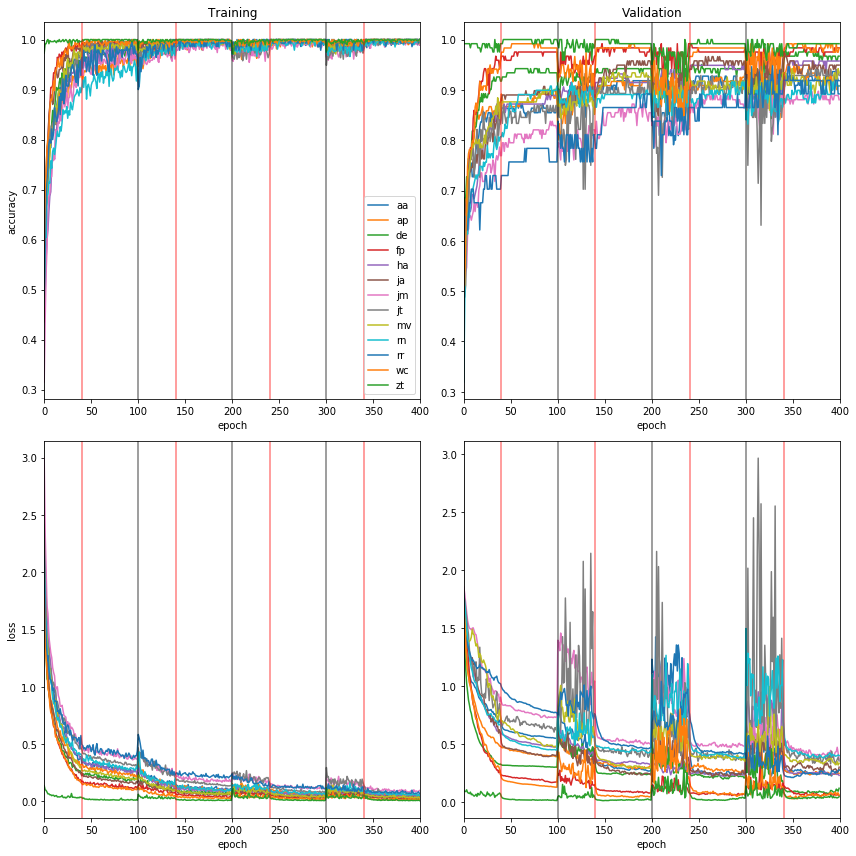

In [15]:
def plt_hist(key):
    # Uses data from outer scope
    sess_breaks = np.arange(N_ITERS_ACROSS_SESS) * (N_EPOCHS_SF + N_EPOCHS_FINETUNE)
    finetune_breaks = sess_breaks + N_EPOCHS_SF
    
    for p_name in train_participants:
        dat = np.hstack([_[key] for _ in hists[p_name]])
        plt.plot(dat, label=p_name)
        plt.xlim([0, N_ITERS_ACROSS_SESS * (N_EPOCHS_SF + N_EPOCHS_FINETUNE)])
    
    for xx in sess_breaks:
        plt.axvline(xx, color='k', alpha=0.5)
    for xx in finetune_breaks:
        plt.axvline(xx, color='r', alpha=0.5)
        
    plt.xlabel('epoch')

fig = plt.figure(figsize=(12, 12), facecolor='white')
plt.subplot(2, 2, 1)
plt_hist('accuracy')
plt.ylabel('accuracy')
plt.title('Training')
plt.legend(loc='lower right')

plt.subplot(2, 2, 2)
plt_hist('val_accuracy')
plt.title('Validation')

plt.subplot(2, 2, 3)
plt_hist('loss')
plt.ylabel('loss')

plt.subplot(2, 2, 4)
plt_hist('val_loss')

plt.tight_layout()
plt.show()

Classification accuracy on the validation set seems to improve as the shared models are updated with each recording.

Validation loss improves for many but not all data sets.

## Transfer the model to unseen data

A single 'test participant' was not included in the above training. Let's see how well we can classify data from this participant using a model that is pre-initialized with weights learned from other subjects and a naive model with random initial weights.

In [16]:
# First clear all models from memory.
reset_keras(shared_head)
reset_keras(shared_tail)

# Build the full naive model using untrained layers.
naive_model = tf.keras.Sequential([
    tf.keras.models.load_model(datadir / 'models' / 'shared_head_naive.h5'),
    *ss_layers[test_participant],
    tf.keras.models.load_model(datadir / 'models' / 'shared_tail_naive.h5')
], name=test_participant + '_naive')
naive_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])

# Backup the naive weights for the full model
naive_model.save_weights(str(datadir / 'models' / (test_participant + '_full_naive.h5')))
    
# Get the transfer model.
xfer_model = tf.keras.Sequential([
    tf.keras.models.load_model(datadir / 'models' / 'shared_head.h5'),
    *ss_layers[test_participant],
    tf.keras.models.load_model(datadir / 'models' / 'shared_tail.h5')
], name='xfer_full')
xfer_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])

297885


W0910 02:48:48.877947 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:48:48.954413 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


184


W0910 02:48:49.173217 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.
W0910 02:48:49.248906 139761148417856 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [17]:
N_EPOCHS = 200
N_EPOCHS_SF = 20
shared_layers = [0, 2]

rec_info = rec_infos[test_participant]

# Load data for this session
X, Y, ax_info = load_faces_houses(datadir, test_participant, feature_set='full')

# Prepare the data for DL
ds_train, ds_valid, n_train = get_ds_train_valid(X, Y,
                                                 rec_info['trn'],
                                                 rec_info['tst'],
                                                 batch_size=BATCH_SIZE,
                                                 max_offset=MAX_OFFSET)

# Train model
print("Training xfer model {} spatial filter".format(xfer_model.name))
xfer_model.layers[0].trainable = False
xfer_model.layers[-1].trainable = False
xfer_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])
hist_xfer_sf = xfer_model.fit(x=ds_train,
                              epochs=N_EPOCHS_SF,
                              validation_data=ds_valid,
                              verbose=1)

print("Training xfer model {} entirity".format(xfer_model.name))
xfer_model.layers[0].trainable = True
xfer_model.layers[-1].trainable = True
xfer_model.compile(loss='sparse_categorical_crossentropy',
                   optimizer='Nadam', metrics=['accuracy'])
hist_xfer_all = xfer_model.fit(x=ds_train,
                               epochs=N_EPOCHS - N_EPOCHS_SF,
                               validation_data=ds_valid,
                               verbose=1)
print("Ending acc and val acc: {:.3f}, {:.3f}".format(
    hist_xfer_all.history['accuracy'][-1], hist_xfer_all.history['val_accuracy'][-1]))

# Train naive model
print("Training naive model {}".format(naive_model.name))
# Restore naive weights.
naive_model.load_weights(str(datadir / 'models' / (test_participant + '_full_naive.h5')))
naive_model.compile(loss='sparse_categorical_crossentropy',
                    optimizer='Nadam', metrics=['accuracy'])
hist_naive = naive_model.fit(x=ds_train,
                             epochs=N_EPOCHS,
                             validation_data=ds_valid,
                             verbose=1)
print("Ending acc and val acc: {:.3f}, {:.3f}".format(
    hist_naive.history['accuracy'][-1], hist_naive.history['val_accuracy'][-1]))

Training xfer model xfer_full spatial filter
Epoch 1/20
45/45 [==============================] - 1s 25ms/step - loss: 3.1455 - accuracy: 0.5133 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/20
45/45 [==============================] - 0s 9ms/step - loss: 1.6509 - accuracy: 0.7156 - val_loss: 1.6942 - val_accuracy: 0.5398
Epoch 3/20
45/45 [==============================] - 0s 9ms/step - loss: 1.2806 - accuracy: 0.8000 - val_loss: 1.4744 - val_accuracy: 0.6195
Epoch 4/20
45/45 [==============================] - 0s 9ms/step - loss: 1.0636 - accuracy: 0.8444 - val_loss: 1.3364 - val_accuracy: 0.6814
Epoch 5/20
45/45 [==============================] - 0s 9ms/step - loss: 0.9513 - accuracy: 0.8733 - val_loss: 1.2383 - val_accuracy: 0.7345
Epoch 6/20
45/45 [==============================] - 0s 9ms/step - loss: 0.7848 - accuracy: 0.9089 - val_loss: 1.1362 - val_accuracy: 0.7788
Epoch 7/20
45/45 [==============================] - 0s 9ms/step - loss: 0.7867 - accuracy: 0.9133 - val_lo

Epoch 38/180
45/45 [==============================] - 1s 13ms/step - loss: 0.1703 - accuracy: 0.9933 - val_loss: 0.4050 - val_accuracy: 0.9292
Epoch 39/180
45/45 [==============================] - 1s 13ms/step - loss: 0.1557 - accuracy: 0.9911 - val_loss: 0.4218 - val_accuracy: 0.9204
Epoch 40/180
45/45 [==============================] - 1s 12ms/step - loss: 0.1570 - accuracy: 0.9911 - val_loss: 0.5019 - val_accuracy: 0.9027
Epoch 41/180
45/45 [==============================] - 1s 13ms/step - loss: 0.1467 - accuracy: 0.9911 - val_loss: 0.4706 - val_accuracy: 0.9027
Epoch 42/180
45/45 [==============================] - 1s 13ms/step - loss: 0.1567 - accuracy: 0.9867 - val_loss: 0.4501 - val_accuracy: 0.9115
Epoch 43/180
45/45 [==============================] - 1s 12ms/step - loss: 0.1533 - accuracy: 0.9867 - val_loss: 0.4712 - val_accuracy: 0.9204
Epoch 44/180
45/45 [==============================] - 1s 12ms/step - loss: 0.1540 - accuracy: 0.9867 - val_loss: 0.3602 - val_accuracy: 0.9027

45/45 [==============================] - 1s 12ms/step - loss: 0.1310 - accuracy: 0.9889 - val_loss: 0.1905 - val_accuracy: 0.9292
Epoch 153/180
45/45 [==============================] - 1s 12ms/step - loss: 0.1182 - accuracy: 0.9933 - val_loss: 0.1323 - val_accuracy: 0.9823
Epoch 154/180
45/45 [==============================] - 1s 12ms/step - loss: 0.1161 - accuracy: 0.9889 - val_loss: 0.1629 - val_accuracy: 0.9735
Epoch 155/180
45/45 [==============================] - 1s 12ms/step - loss: 0.1041 - accuracy: 0.9933 - val_loss: 0.1545 - val_accuracy: 0.9735
Epoch 156/180
45/45 [==============================] - 1s 12ms/step - loss: 0.1125 - accuracy: 0.9911 - val_loss: 0.2476 - val_accuracy: 0.9381
Epoch 157/180
45/45 [==============================] - 1s 12ms/step - loss: 0.0913 - accuracy: 1.0000 - val_loss: 0.1567 - val_accuracy: 0.9823
Epoch 158/180
45/45 [==============================] - 1s 12ms/step - loss: 0.1044 - accuracy: 0.9933 - val_loss: 0.2127 - val_accuracy: 0.9469
Epoch 

Epoch 29/200
45/45 [==============================] - 1s 12ms/step - loss: 0.1719 - accuracy: 0.9756 - val_loss: 0.3721 - val_accuracy: 0.8850
Epoch 30/200
45/45 [==============================] - 1s 12ms/step - loss: 0.1658 - accuracy: 0.9756 - val_loss: 0.3859 - val_accuracy: 0.9027
Epoch 31/200
45/45 [==============================] - 1s 13ms/step - loss: 0.1502 - accuracy: 0.9844 - val_loss: 0.4140 - val_accuracy: 0.8761
Epoch 32/200
45/45 [==============================] - 1s 13ms/step - loss: 0.1716 - accuracy: 0.9867 - val_loss: 0.3444 - val_accuracy: 0.9292
Epoch 33/200
45/45 [==============================] - 1s 13ms/step - loss: 0.1432 - accuracy: 0.9867 - val_loss: 0.3343 - val_accuracy: 0.9204
Epoch 34/200
45/45 [==============================] - 1s 13ms/step - loss: 0.1246 - accuracy: 0.9889 - val_loss: 0.3069 - val_accuracy: 0.9027
Epoch 35/200
45/45 [==============================] - 1s 13ms/step - loss: 0.1222 - accuracy: 0.9911 - val_loss: 0.4042 - val_accuracy: 0.8938

45/45 [==============================] - 1s 13ms/step - loss: 0.0914 - accuracy: 0.9933 - val_loss: 0.3011 - val_accuracy: 0.8850
Epoch 144/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0848 - accuracy: 0.9956 - val_loss: 0.0901 - val_accuracy: 0.9912
Epoch 145/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0704 - accuracy: 0.9978 - val_loss: 0.2397 - val_accuracy: 0.9469
Epoch 146/200
45/45 [==============================] - 1s 12ms/step - loss: 0.1118 - accuracy: 0.9867 - val_loss: 0.1954 - val_accuracy: 0.9646
Epoch 147/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0928 - accuracy: 0.9956 - val_loss: 0.2309 - val_accuracy: 0.9558
Epoch 148/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0796 - accuracy: 0.9956 - val_loss: 0.1407 - val_accuracy: 0.9558
Epoch 149/200
45/45 [==============================] - 1s 12ms/step - loss: 0.0844 - accuracy: 0.9933 - val_loss: 0.1950 - val_accuracy: 0.9558
Epoch 

Epoch 200/200
45/45 [==============================] - 1s 12ms/step - loss: 0.1448 - accuracy: 0.9733 - val_loss: 0.1789 - val_accuracy: 0.9646
Ending acc and val acc: 0.973, 0.965


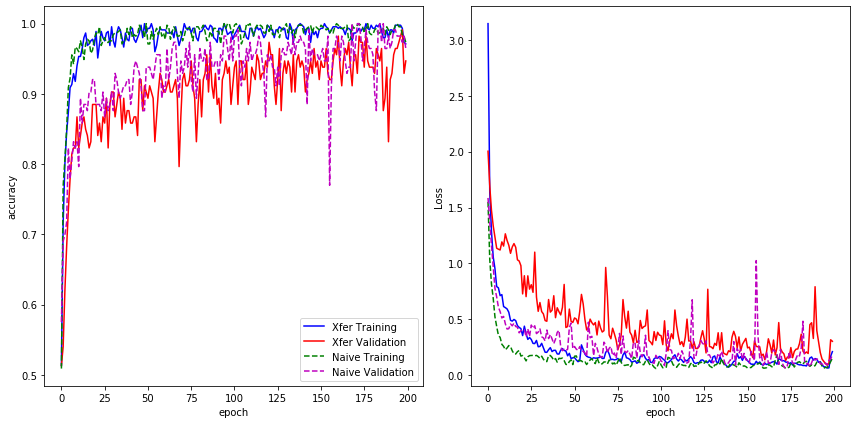

In [21]:
fig = plt.figure(figsize=(12, 6), facecolor='white')
hist_xfer = {}
for k in hist_xfer_sf.history.keys():
    hist_xfer[k] = hist_xfer_sf.history[k] + hist_xfer_all.history[k]
plt.subplot(1, 2, 1)
plt.plot(hist_xfer['accuracy'], 'b', label='Xfer Training')
plt.plot(hist_xfer['val_accuracy'], 'r', label='Xfer Validation')
plt.plot(hist_naive.history['accuracy'], 'g--', label='Naive Training')
plt.plot(hist_naive.history['val_accuracy'], 'm--', label='Naive Validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.subplot(1, 2, 2)
plt.plot(hist_xfer['loss'], 'b', label='Xfer Training')
plt.plot(hist_xfer['val_loss'], 'r', label='Xfer Validation')
plt.plot(hist_naive.history['loss'], 'g--', label='Naive Training')
plt.plot(hist_naive.history['val_loss'], 'm--', label='Naive Validation')
plt.ylabel('Loss')
plt.xlabel('epoch')

plt.tight_layout()
plt.show()

oof. Not what we were hoping for. The model with randomly-initialized weights (naive) trained faster. However, the transfer model (Xfer) had better peak performance.

There are a couple things we could do differently:

1. For each session, including the test session, the spatial filter should be initialized with an unsupervised method.
2. The intended use case of the transfer model on a new dataset is to given decent performance when there is a paucity of training data. We can simulate that by running the above analysis for different levels of training data.